Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Описание колонок:
- value – значения метрики
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест)  

Задача:  
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [120]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

In [121]:
df2 = pd.read_csv('hw_bootstrap.csv', sep=';')

In [122]:
df = pd.read_csv('hw_bootstrap.csv', sep=';', usecols=['value', 'experimentVariant'])

In [123]:
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [124]:
# приведем колонку к типу float
df['value'] = df.value.str.replace(',', '.').astype(np.float64)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


Построим boxplot для визального изучения данных

In [126]:
gr_control = df.query('experimentVariant == "Control"')
gr_treatment = df.query('experimentVariant == "Treatment"')

<AxesSubplot:xlabel='value', ylabel='experimentVariant'>

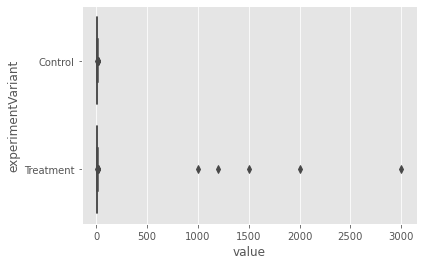

In [127]:
sns.boxplot(data=df, x=df.value, y=df.experimentVariant) 

Мешают выбросы. Уберем их: showfliers = False

<AxesSubplot:xlabel='value', ylabel='experimentVariant'>

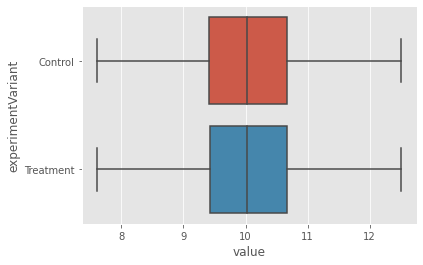

In [128]:
sns.boxplot(data=df, x=df.value, y=df.experimentVariant, showfliers = False) 

In [129]:
A = gr_control.value
B = gr_treatment.value

В тестовой группе есть довольно сильные выбросы, поэтому ттест скорее всего не подойдет - увеличит вероятность ошибки первого рода. проверим p-value

In [130]:
stats.ttest_ind(gr_control.value, gr_treatment.value)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

p < $\alpha$ ttest находит статзначимые различия

Вряд ли дисперсии гомогенны, но подкрепим выводы на основе графического изображения научным походом на гомогенность дисперсий (Левен)

In [131]:
stats.levene(A, B)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

То же самое и с нормальностью - явно тестовая группа ненормальна.

In [132]:
print(f'pvalue A = {stats.shapiro(A)[1]}')
print(f'pvalue B = {stats.shapiro(B)[1]}')

pvalue A = 0.22416365146636963
pvalue B = 1.0930128021733573e-43


Так и есть - тест группа не является выборкой из ген совокупности с нормальным распределением

Для больших отклонений и ненормального распределения с выбросами больше подходит непараметр тест Манна-Уитни

In [133]:
stats.mannwhitneyu(A, B)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Так и есть - p > $\alpha$. Ман Уитни подтверждает 0 гипотезу - между выборками нет стат значимой разницы

Теперь проведем bootstrap анализ

In [134]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=20, linestyle='--', colors="b")
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

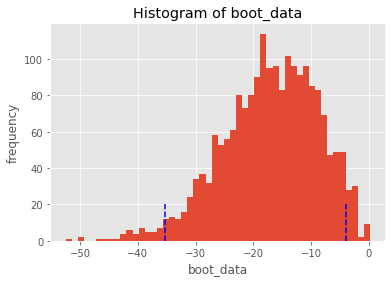

In [135]:
booted_data = get_bootstrap(A, B, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [136]:
booted_data["p_value"]

0.03835227495013548

Удостоверимся, что выборки отличаются только небольшим кол-вом значений.

In [152]:
diff = (A-B.reset_index(drop=True))
diff[diff != 0]

495    -989.026071
496   -1189.738926
497   -1491.219910
498   -1988.830922
499   -2988.500434
Name: value, dtype: float64

Выводы: 
 
т.к. наши выборки отличаются только за счет всего нескольких выбросов в тесте (в остальном они абслосютно идентичны). Следовательно мы можем сделать вывод - что отличие сформировано за счет скорее случайных выбросов (случайная покупка, ...), и ими можно принебречь. Хотя они (выбросы) представляют определенный интерес для изучения, но это уже другой вопрос.

В данном случае стоит использовать <ins>непараметр тест Манна-Уитни</ins>, согласно которому pvalue=0.86, что говорит об отсуствии стат значимого различия.
